In [2]:
import pandas as pd
SELECT_COLUMN = [1,2,4,6,11] # We only consider price, date of the purchase, property type, lease duration and town
df = pd.read_csv("data/pp-complete.csv", names=["price", "date", "ptype", "duration", "town"], sep=",", usecols=SELECT_COLUMN)

In [3]:
# Data Preprocessing
for c in ['duration', 'ptype']:
    df[c] = df[c].astype('category')
    df[c] = df[c].cat.codes

df['isLondon'] = [1 if i == "LONDON" else 0 for i in df['town']]
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d')
df["year"] = df['date'].dt.year

In [165]:
from sklearn.preprocessing import OneHotEncoder
# creating instance of one-hot-encoder
enc = OneHotEncoder()

In [156]:
a = enc.fit_transform(df[['ptype', 'duration', 'isLondon']]).toarray()

In [157]:
a.shape

(23991146, 10)

In [107]:
df['price'] = df['price'].astype('int')

In [119]:
df = df.drop_duplicates()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12bc51f28>]],
      dtype=object)

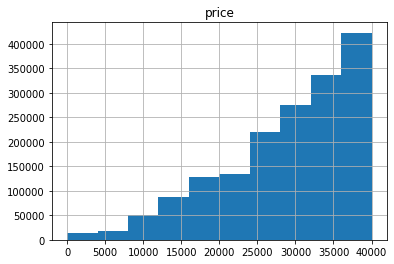

In [182]:
df[(df.price > 1) & (df.price <=40000)].hist("price")

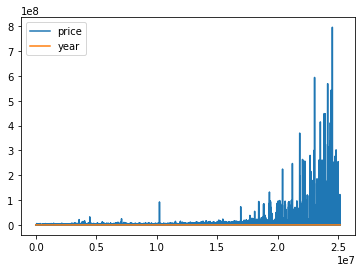

In [183]:
df[['price', 'year']].plot()

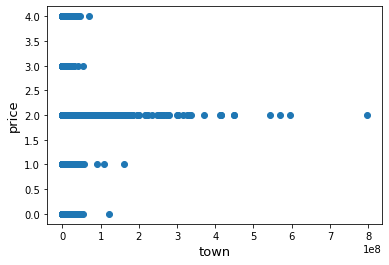

In [185]:
fig, ax = plt.subplots()
ax.scatter(x = df['price'], y = df['ptype'])
plt.ylabel('price', fontsize=13)
plt.xlabel('town', fontsize=13)
plt.show()

In [142]:
sdf = df[(df.price > 10000) & (df.price <=100000)]

In [168]:
enc.fit(sdf[['ptype', 'duration', 'isLondon']])


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [180]:
sdf['price'].mean()

146538.4129934127

In [175]:
# Split the data into training/testing sets
def split_train_test_data(df):
    df_train = df[df.date < "2016-1-1"]
    df_test = df[df.date >= "2016-1-1"]
    df_test = df_test[df.date < "2017-1-1"]
    x_train = enc.transform(df_train[['ptype', 'duration', 'isLondon']]).toarray()
    y_train = df_train['price'].values

    x_test = enc.transform(df_test[['ptype', 'duration', 'isLondon']]).toarray()
    y_test = df_test['price'].values
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_train_test_data(sdf)

/Users/jarana/anaconda3/envs/torch1/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [170]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import numpy as np

In [177]:
x_test.shape, x_train.shape

((819049, 10), (18880708, 10))

In [181]:
# Create linear regression model
model = linear_model.LinearRegression()
# Train the model using the training set
model.fit(x_train, y_train)
# Make predictions using the testing set
y_pred = model.predict(x_test)
# The mean squared error
print('Mean squared error: %f'
      % mean_squared_error(y_test, y_pred))

Mean squared error: 10974531174.575642


In [187]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [189]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 84991.0247 (10704.0893)



In [191]:
from sklearn.metrics import mean_squared_error, r2_score

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso.fit(x_train, y_train)


-11.250299423714775

In [192]:
y_pred = lasso.predict(x_test)

In [193]:
y_pred

array([193075.68361997, 116498.7767857 , 111952.91656562, ...,
       174590.70592195, 174590.70592195, 174590.70592195])

In [194]:
y_test

array([385000, 213000, 215000, ..., 210000, 315000, 180000])

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet.fit(x_train, y_train)
r2_score(ENet.predict(x_test), y_test)

In [51]:
# Mean squared error: 3117030559359.05
from sklearn import linear_model
model = linear_model.BayesianRidge()
model.fit(x_train, y_train)
y_pred = model.predict(x_train)
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_pred))

Mean squared error: 107152450429.51


In [93]:
import keras
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define the model
def baseline():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model = baseline()
for i in range(1):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    print('Mean squared error: %.2f'
          % mean_squared_error(y_train, y_pred))

Epoch 1/1
21019102/21019102 [==============================] - 457s 22us/step - loss: 116823596538.7392
Mean squared error: 116313444397.51


In [92]:
if __name__ == "__main__":

    SELECT_COLUMN = [1,2,4,6,11] # We only consider price, date of the purchase, property type, lease duration and town
    df = pd.read_csv("data/pp-complete.csv", names=["price", "date", "ptype", "duration", "town"], sep=",", usecols=SELECT_COLUMN)

    for c in ['duration', 'ptype']:
        df[c] = df[c].astype('category')
        df[c] = df[c].cat.codes

    df['isLondon'] = [1 if i == "LONDON" else 0 for i in df['town']]
    df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d')
    df["year"] = df['date'].dt.year

    # Split the data into training/testing sets
    df_train = df[df.date < "2016-1-1"]
    df_test = df[df.date >= "2016-1-1"]
    #df_test = df_test[df.date < "2017-1-1"]
    x_train = df_train[['ptype', 'duration', 'isLondon']].values
    y_train = df_train['price'].values

    x_test = df_test[['ptype', 'duration', 'isLondon']].values
    y_test = df_test['price'].values


    # define the model
    def baseline():
        # create model
        model = Sequential()
        model.add(Dense(3, input_dim=3, activation='relu'))
        model.add(Dense(1))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model
    model = baseline()
    for i in range(10):
        model.fit(x_train, y_train, batch_size=128)
        results = model.evaluate(x_test, y_test, batch_size=128, verbose=0)
        print("mse:", results)
        #y_pred = model.predict(x_train)
        #print('Mean squared error: %.2f'
        #      % mean_squared_error(y_train, y_pred))

KeyboardInterrupt: 

In [88]:
for i in range(3):
    model.fit(x_train, y_train, batch_size=512)
#     y_pred = model.predict(x_train)
    results = model.evaluate(x_test, y_test, batch_size=512, verbose=0)
    print("mse:", results)
#     print('Mean squared error: %.2f'
#           % mean_squared_error(y_train, y_pred))

Epoch 1/1
100/100 [==============================] - 0s 12us/step - loss: 13572511744.0000
mse: 154681229312.0
Epoch 1/1
100/100 [==============================] - 0s 12us/step - loss: 13496384512.0000
mse: 154803863552.0
Epoch 1/1
100/100 [==============================] - 0s 14us/step - loss: 13419431936.0000
mse: 154928267264.0


In [81]:
y_pred = model.predict(x_train)
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_pred))

Mean squared error: 112481184635.64


In [79]:
# Create linear regression model
lr = linear_model.LinearRegression()
# Train the model using the training set
lr.fit(x_train, y_train)
# Make predictions using the testing set
y_pred = lr.predict(x_test)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

Mean squared error: 1273890082961.85


In [ ]:
3112571893367.58

3072782252693.90
112481184635.64

In [80]:

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, [df.price.mean()]*len(y_test)))

Mean squared error: 1305082261008.95


In [14]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
pipe = Pipeline([
('sc',StandardScaler()),
('poly',PolynomialFeatures(include_bias=True)),
('reg',LinearRegression())
])
model = GridSearchCV(pipe,param_grid={'poly__degree':[2,3]})
model.fit(x_train, y_train)
degree = model.best_params_
print(degree)
pred = np.exp(model.predict(x_test))
Accuracy = sqrt(mse(y_test, pred))
print('=='*20+'RMSE: '+str(Accuracy)+'=='*20)
RMSE.append(Accuracy)

{'poly__degree': 2}


/Users/jarana/anaconda3/envs/torch1/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


NameError: name 'sqrt' is not defined

In [17]:
Accuracy = mse(y_test, model.predict(x_test))
print('=='*20+'RMSE: '+str(Accuracy)+'=='*20)


========================================RMSE: 3055499977402.7954========================================


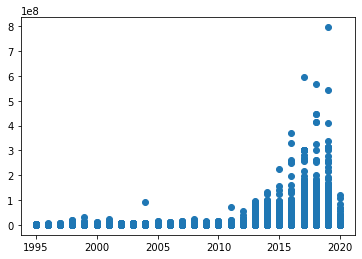

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df['year'] , df['price'])

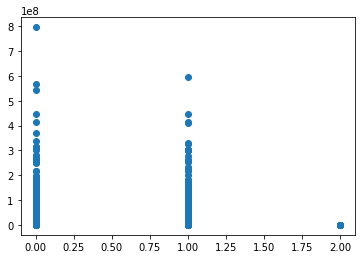

In [25]:
plt.scatter(df['duration'] , df['price'])

(array([5795383.,       0., 4553457.,       0.,       0.,  279397.,
              0., 6921919.,       0., 7630528.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

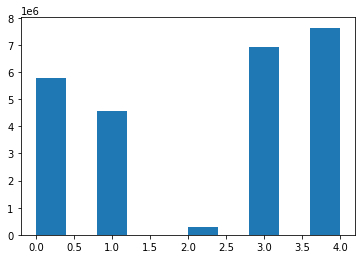

In [32]:
plt.hist(df['ptype'])

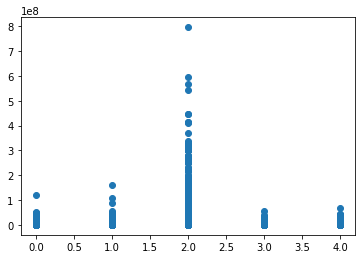

In [27]:
plt.scatter(df['ptype'] , df['price'])

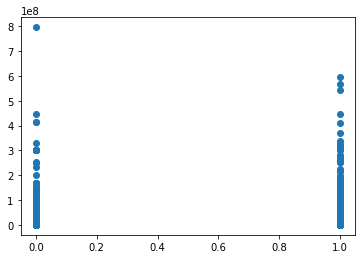

In [28]:
plt.scatter(df['isLondon'] , df['price'])